<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/Unet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1RfN4XDprnJCyq7sFjCbj1o68qDv4dIjg'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)
!unzip dataset.zip

%pip install --pre deeptrack
%pip install deeplay

Downloading...
From (original): https://drive.google.com/uc?id=1RfN4XDprnJCyq7sFjCbj1o68qDv4dIjg
From (redirected): https://drive.google.com/uc?id=1RfN4XDprnJCyq7sFjCbj1o68qDv4dIjg&confirm=t&uuid=ef29a616-09d8-4335-a625-76a8315a7a44
To: /content/dataset.zip
100%|██████████| 1.65G/1.65G [00:11<00:00, 144MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: Output/Tp_paded/Tp_S_NRN_S_B_cha10101_cha10101_10050.png  
  inflating: Output/Tp_paded/Tp_D_NRN_S_N_art00099_ani00005_00539.png  
  inflating: Output/Tp_paded/Tp_S_NRD_S_N_cha00066_cha00066_00857.png  
  inflating: Output/Tp_paded/Tp_S_CRN_M_N_art00021_art00021_10547.png  
  inflating: Output/Tp_paded/Tp_D_NND_S_N_nat00011_nat00007_00631.png  
  inflating: Output/Tp_paded/Tp_S_CRD_M_B_sec00083_sec00083_11287.png  
  inflating: Output/Tp_paded/Tp_D_NRN_S_B_ani00036_ani00037_00156.png  
  inflating: Output/Tp_paded/Tp_S_NNN_S_N_ind00087_ind00087_01371.png  
  inflating: Output/Tp_paded/Tp_S_NNN_S_N_sec00064_sec00064_11259.png  
  inflating: Output/Tp_paded/Tp_D_NRN_M_N_art10108_cha10110_11575.png  
  inflating: Output/Tp_paded/Tp_S_NNN_S_N_art00046_art00046_11923.png  
  inflating: Output/Tp_paded/Tp_D_NRN_S_N_art00041_ani00005_01413.png  
  inflating: Output/Tp_paded/Tp_D_NRN_S_N_pla00023_pla00019_10955.png  
  inflating: 

In [2]:
import deeptrack as dt

raw_path="/content/Output/Tp_paded/"
label_path="/content/Output/Gt_paded/"

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)
paths = dt.sources.Source(raw=raw_paths, label=label_paths)
train_paths, val_paths, test_paths = dt.sources.random_split(paths,
                                                             [0.8, 0.1, 0.1])

train_srcs = train_paths.product()
val_srcs = val_paths.constants()
test_srcs = test_paths.constants()

sources = dt.sources.Join(train_srcs, val_srcs, test_srcs)

In [3]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, raw_dir, label_dir, transform=None):
        self.raw_dir = raw_dir
        self.label_dir = label_dir
        self.transform = transform

        # List the files in the raw and label directories
        self.raw_files = sorted(os.listdir(raw_dir))
        self.label_files = sorted(os.listdir(label_dir))

    def __len__(self):
        # Make sure the number of raw files and label files match
        assert len(self.raw_files) == len(self.label_files), \
            "The number of raw and label files should be the same"
        return len(self.raw_files)

    def __getitem__(self, idx):
        # Load raw image
        raw_path = os.path.join(self.raw_dir, self.raw_files[idx])
        raw_image = Image.open(raw_path).convert('RGB')

        # Load label image
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        label_image = Image.open(label_path).convert('L')  # Convert to grayscale

        # Convert images to numpy arrays
        raw_image = np.array(raw_image)
        label_image = np.array(label_image)

        # Convert label image to binary mask
        label_image = (label_image == 255).astype(np.uint8)

        # Apply transformations, if any
        if self.transform:
            raw_image = self.transform(raw_image)
            label_image = self.transform(label_image)

        # Convert images to PyTorch tensors
        raw_image = torch.from_numpy(raw_image).float().div(255)
        label_image = torch.from_numpy(label_image).float()

        # Permute raw_image to move the channels to the first dimension [C, H, W]
        raw_image = raw_image.permute(2, 0, 1)

        # Ensure label image is a single-channel tensor [1, H, W]
        label_image = label_image.unsqueeze(0)  # Add channel dimension

        return raw_image, label_image
# Define any transforms here - for now, we are not applying any
transform = None

# Create the datasets
train_dataset = CustomDataset(raw_path, label_path, transform=transform)

# Now, when you get a sample from the dataset, the label should be binary
image, label = train_dataset[0]
print(image.shape)  # Should be [3, height, width]
print(label.shape)  # Should be [1, height, width]


torch.Size([3, 400, 400])
torch.Size([1, 400, 400])


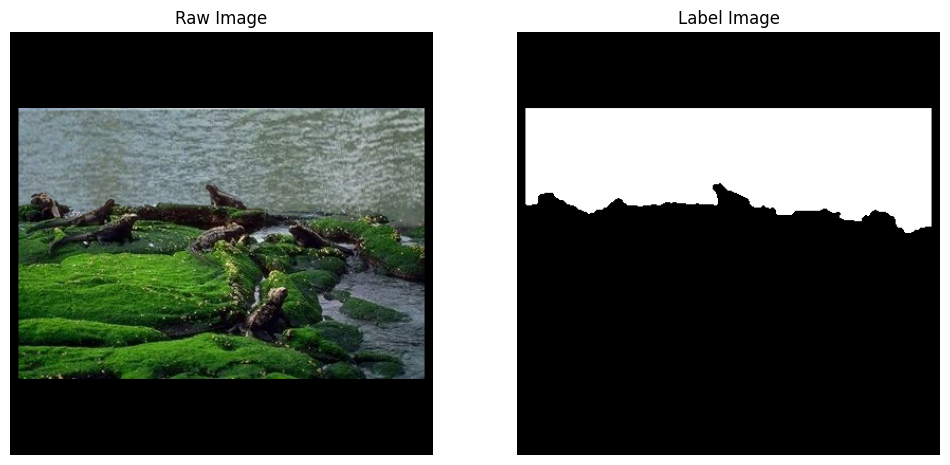

In [4]:
import matplotlib.pyplot as plt

# Assuming you have already loaded an image and label using your dataset
image, label = train_dataset[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Set up a figure with two subplots

# Plot the raw image
# image is [C, H, W], permute to [H, W, C] for plotting
axs[0].imshow(image.permute(1, 2, 0))
axs[0].set_title('Raw Image')
axs[0].axis('off')  # Hide the axes

# Plot the label image
# label is [1, H, W], squeeze to remove the channel dimension for plotting
axs[1].imshow(label.squeeze(), cmap='gray')
axs[1].set_title('Label Image')
axs[1].axis('off')  # Hide the axes

plt.show()


In [ ]:
import torch
import deeplay as dl
from torchmetrics import JaccardIndex

class BinaryJI(JaccardIndex):
    """Compute Jaccard Index for binary predictions."""

    def update(self, preds, target):
        preds = torch.sigmoid(preds)  # Apply sigmoid to get [0,1] probabilities
        preds = (preds > 0.5).int()   # Threshold probabilities to get binary predictions
        super().update(preds, target)

# Initialize Jaccard Index for binary classification
ji_metric = BinaryJI(num_classes=1, task="binary")
unet = dl.UNet2d(
    in_channels=3,
    channels=[16, 32, 64, 128],
    out_channels=1,  # One output channel for binary segmentation
    skip=dl.Cat(),
)
unet_reg_template = dl.Regressor(
    model=unet,
    loss=torch.nn.BCEWithLogitsLoss(),  # Use BCEWithLogitsLoss for binary output
    metrics=[ji_metric],
    optimizer=dl.Adam(),
)
unet_reg = unet_reg_template.create()
print(unet_reg)


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12)

NameError: name 'val_dataset' is not defined

In [ ]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="train_100_epochs")
trainer = dl.Trainer(max_epochs=100, accelerator="auto", logger=logger)
trainer.fit(unet_reg, train_loader, val_loader)